In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Application_Data.csv')
df.head().style.background_gradient(cmap='YlOrBr').set_properties(**{'font-family': 'Segoe UI'}).hide(axis='index')

Applicant_ID,Applicant_Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,Owned_Mobile_Phone,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Applicant_Age,Years_of_Working,Total_Bad_Debt,Total_Good_Debt,Status
5008806,M,1,1,0,112500,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2,59,4,0,30,1
5008808,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53,9,0,5,1
5008809,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53,9,0,5,1
5008810,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53,9,0,27,1
5008811,F,0,1,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53,9,0,39,1


In [3]:
print('\033[93m\033[1m'+'.: Imported Dataset Info :.'+'\033[0m')
print('\033[93m*' * 28+'\033[0m')
print('Total Rows:'+'\033[93m\033[1m', df.shape[0])
print('\033[0m'+'Total Columns:'+'\033[93m\033[1m', df.shape[1])
print('\033[0m\033[93m'+'*' * 28+'\033[0m')
print('\n')

# --- Print Dataset Detail ---
print('\033[93m\033[1m'+'.: Dataset Details :.'+'\033[0m')
print('\033[0m\033[93m'+'*' * 22+'\033[0m')
df.info(memory_usage = False)

.: Imported Dataset Info :.
****************************
Total Rows: 25128
Total Columns: 21
****************************


.: Dataset Details :.
**********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25128 entries, 0 to 25127
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant_ID          25128 non-null  int64 
 1   Applicant_Gender      25128 non-null  object
 2   Owned_Car             25128 non-null  int64 
 3   Owned_Realty          25128 non-null  int64 
 4   Total_Children        25128 non-null  int64 
 5   Total_Income          25128 non-null  int64 
 6   Income_Type           25128 non-null  object
 7   Education_Type        25128 non-null  object
 8   Family_Status         25128 non-null  object
 9   Housing_Type          25128 non-null  object
 10  Owned_Mobile_Phone    25128 non-null  int64 
 11  Owned_Work_Phone      25128 non-null  int64 
 12  Owned_Phone      

In [4]:
df.drop(columns=['Owned_Mobile_Phone'], inplace=True)

In [5]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

    print(df[col].unique())

['M' 'F']
['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']


In [6]:
df.isna().sum()

Applicant_ID            0
Applicant_Gender        0
Owned_Car               0
Owned_Realty            0
Total_Children          0
Total_Income            0
Income_Type             0
Education_Type          0
Family_Status           0
Housing_Type            0
Owned_Work_Phone        0
Owned_Phone             0
Owned_Email             0
Job_Title               0
Total_Family_Members    0
Applicant_Age           0
Years_of_Working        0
Total_Bad_Debt          0
Total_Good_Debt         0
Status                  0
dtype: int64

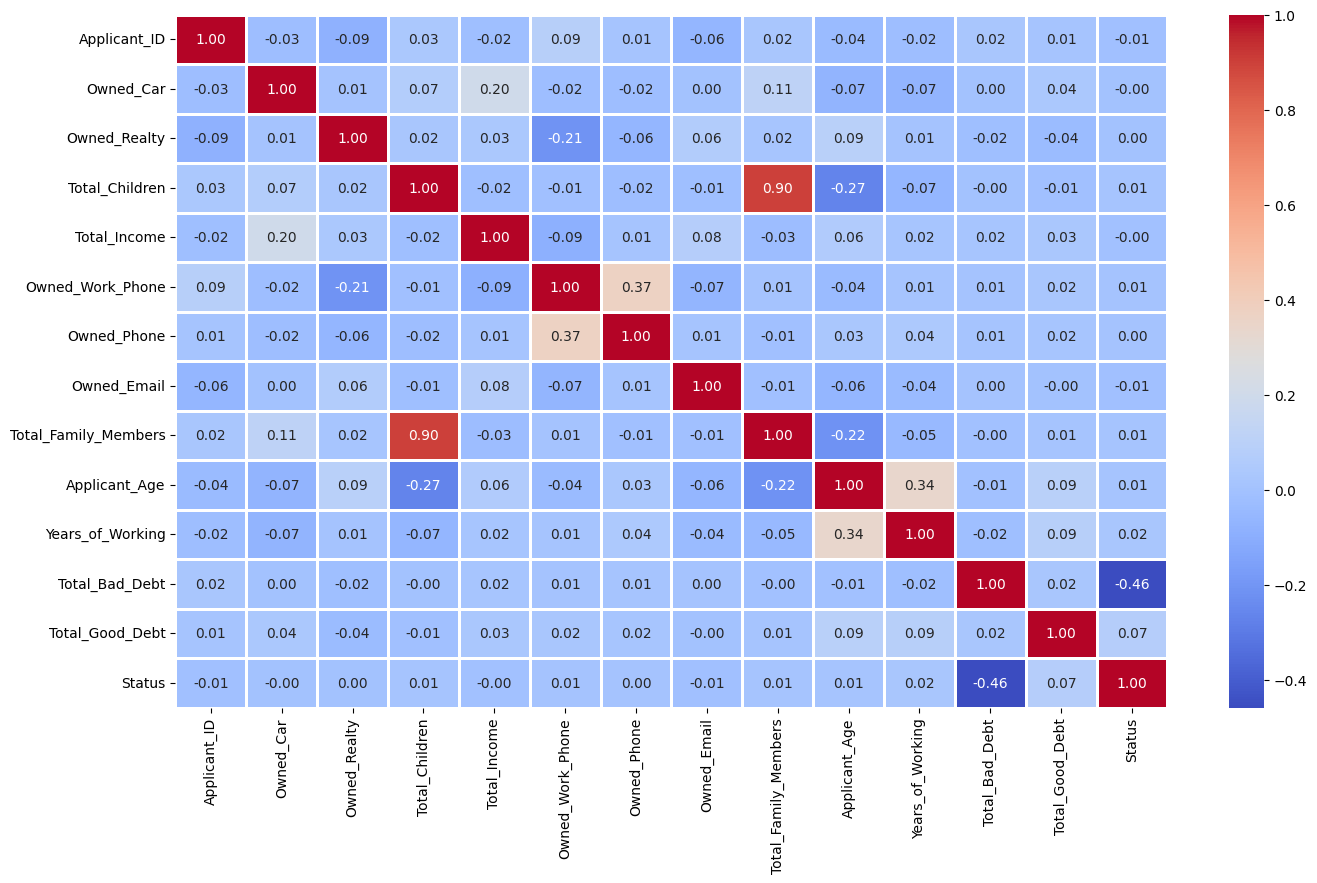

In [7]:
num_cols = df.select_dtypes(include='number').columns
plt.figure(figsize=(16, 9))
sns.heatmap(data=df[num_cols].corr(), annot=True, linewidths=1, fmt='.2f', cmap='coolwarm')
plt.show()

<Axes: xlabel='Status', ylabel='count'>

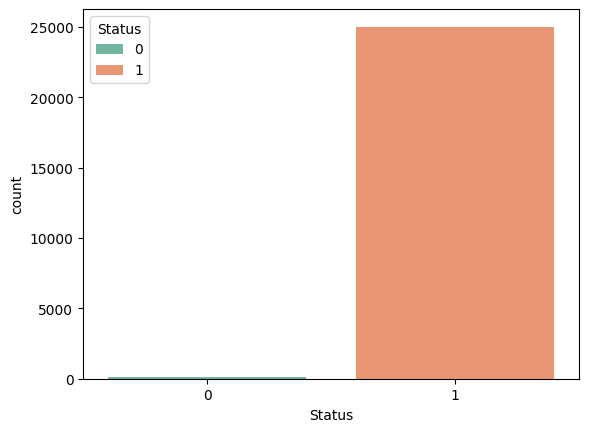

In [8]:
sns.countplot(x='Status', data=df, hue='Status', palette='Set2')

In [9]:
# --- Create Prediction & Modeling Data ---
df_modeling = df.sample(frac=0.9, random_state=42)
df_unseen = df.drop(df_modeling.index)
df_modeling.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)

# --- Shape of Modeling & Prediction Data ---
print('\033[93m\033[1m'+'.: Data for Modeling :.'+'\033[0m')
print('\033[93m*' * 24+'\033[0m')
print('Total Observations / Total columns: ' + str(df_modeling.shape))
print('\n')
print('\033[93m\033[1m'+'.: Data for Predictions (Unseen) :.'+'\033[0m')
print('\033[93m*' * 36+'\033[0m')
print('Total Observations / Total Columns: ' + str(df_unseen.shape))

.: Data for Modeling :.
************************
Total Observations / Total columns: (22615, 20)


.: Data for Predictions (Unseen) :.
************************************
Total Observations / Total Columns: (2513, 20)


In [10]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.replace(' ', '_')

    print(col, df[col].unique())

Applicant_Gender ['M' 'F']
Income_Type ['Working' 'Commercial_associate' 'State_servant' 'Student' 'Pensioner']
Education_Type ['Secondary_/_secondary_special' 'Higher_education' 'Incomplete_higher'
 'Lower_secondary' 'Academic_degree']
Family_Status ['Married' 'Single_/_not_married' 'Civil_marriage' 'Separated' 'Widow']
Housing_Type ['House_/_apartment' 'Rented_apartment' 'Municipal_apartment'
 'With_parents' 'Co-op_apartment' 'Office_apartment']
Job_Title ['Security_staff' 'Sales_staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core_staff' 'High_skill_tech_staff' 'Cleaning_staff'
 'Private_service_staff' 'Cooking_staff' 'Low-skill_Laborers'
 'Medicine_staff' 'Secretaries' 'Waiters/barmen_staff' 'HR_staff'
 'Realty_agents' 'IT_staff']


In [11]:
target = 'Status'
categorical_features = ['Applicant_Gender', 'Income_Type', 'Education_Type', 'Family_Status', 'Housing_Type', 'Job_Title']
ignore_features = ['Applicant_ID']

X = df_modeling.drop(columns=[target] + ignore_features)
y = df_modeling[target]

numerical_features = [col for col in X.columns if col not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
X_train.head()

,Applicant_Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Applicant_Age,Years_of_Working,Total_Bad_Debt,Total_Good_Debt
7370,F,0,1,2,135000,Working,Secondary / secondary special,Separated,House / apartment,0,0,0,Core staff,3,41,7,3,13
7313,M,1,1,0,900000,Working,Higher education,Married,House / apartment,0,0,0,Drivers,2,53,4,0,46
10881,F,0,1,0,135000,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0,0,1,Cleaning staff,2,47,3,0,4
814,F,0,0,1,144000,Working,Secondary / secondary special,Single / not married,Rented apartment,1,1,0,High skill tech staff,2,40,10,0,33
15994,M,0,0,0,90000,Working,Secondary / secondary special,Widow,Municipal apartment,1,1,0,Sales staff,1,55,10,4,14


In [13]:
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sampling_strategy = {
    0: 20000,
    1: 20000,
}

continuous_features = numerical_features

scaling_transformer = SciPipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    # ('scaler', StandardScaler()),
])

# preprocessor = ColumnTransformer(transformers=[
#     ('scaling_transformer', scaling_transformer, continuous_features),
# ], remainder='passthrough', )#force_int_remainder_cols=False

# pipeline = ImbPipeline([
#     ('preprocessor', preprocessor),
#     ('over', SMOTE(random_state=69, sampling_strategy=sampling_strategy)),
#     ('classifier', RandomForestClassifier(n_jobs=6, random_state=69)),
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaling_transformer', scaling_transformer, continuous_features)
    ],
    remainder='passthrough'
)

smote = SMOTE(random_state=123)

# model = RandomForestClassifier(random_state=123, class_weight='balanced')  # Using class_weight as an alternative

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('scaler', StandardScaler(with_mean=False)),  # StandardScaler for numeric features (optional)
    ('classifier', RandomForestClassifier(n_jobs=6, random_state=123))
])


param_grid = [
    {
        'classifier': [LGBMClassifier(n_jobs=6)],
        'classifier__num_leaves': [25],
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.1],
    },
]

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

kf = StratifiedKFold(n_splits=5, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=kf, n_jobs=6, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 18004, number of negative: 18004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11251
[LightGBM] [Info] Number of data points in the train set: 36008, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found:  {'classifier': LGBMClassifier(n_jobs=6), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100, 'classifier__num_leaves': 25}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Applicant_Gender',
                                                   'Income_Type',
                                                   'Education_Type',
                                                   'Family_Status',
                                                   'Housing_Type',
                                                   'Job_Title']),
                                                 ('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Owned_Car', 'Owned_Realty',
                                                   'Total_Children',
                                                   'Total_Income',
                                                   'Owned_Work_Phone',
                                                   'Owned_Phone', 'Owned_Email',
                                                   'Total_Family_Members',
                                                   'Applicant_Age',
                                                   'Years_of_Working',
                                                   'Total_Bad_Debt',
                                                   'Total_Good_Debt'])])),
                ('smote', SMOTE(random_state=123)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', LGBMClassifier(n_jobs=6, num_leaves=25))])

In [15]:
import pickle
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [16]:
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [17]:
data_to_predict = X_test.iloc[991].tolist()

In [25]:
X_test.iloc[991]

Applicant_Gender                                    M
Owned_Car                                           1
Owned_Realty                                        1
Total_Children                                      0
Total_Income                                   180000
Income_Type                                   Working
Education_Type          Secondary / secondary special
Family_Status                                 Married
Housing_Type                        House / apartment
Owned_Work_Phone                                    0
Owned_Phone                                         0
Owned_Email                                         0
Job_Title                                     Drivers
Total_Family_Members                                2
Applicant_Age                                      37
Years_of_Working                                    3
Total_Bad_Debt                                      0
Total_Good_Debt                                    11
Name: 1466, dtype: object

In [18]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [19]:
data_to_predict_df = pd.DataFrame([data_to_predict], columns=X_test.columns)
loaded_model.predict(data_to_predict_df)

array([1])

In [20]:
y_test.iloc[991]

np.int64(1)

In [22]:
for col in X_test.select_dtypes(include='object').columns:
    print(df[col].unique())

['M' 'F']
['Working' 'Commercial_associate' 'State_servant' 'Student' 'Pensioner']
['Secondary_/_secondary_special' 'Higher_education' 'Incomplete_higher'
 'Lower_secondary' 'Academic_degree']
['Married' 'Single_/_not_married' 'Civil_marriage' 'Separated' 'Widow']
['House_/_apartment' 'Rented_apartment' 'Municipal_apartment'
 'With_parents' 'Co-op_apartment' 'Office_apartment']
['Security_staff' 'Sales_staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core_staff' 'High_skill_tech_staff' 'Cleaning_staff'
 'Private_service_staff' 'Cooking_staff' 'Low-skill_Laborers'
 'Medicine_staff' 'Secretaries' 'Waiters/barmen_staff' 'HR_staff'
 'Realty_agents' 'IT_staff']


In [24]:
X_test.head(50)

,Applicant_Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Applicant_Age,Years_of_Working,Total_Bad_Debt,Total_Good_Debt
14155,F,0,1,0,135000,Commercial associate,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,2,45,6,0,4
7641,M,1,1,0,310500,Working,Secondary / secondary special,Married,House / apartment,0,1,1,High skill tech staff,2,47,5,0,42
9534,F,0,0,0,67500,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,2,28,6,0,13
7793,F,0,1,0,202500,Working,Higher education,Separated,House / apartment,0,1,0,High skill tech staff,1,55,12,0,40
11661,F,0,1,0,135000,Working,Higher education,Married,House / apartment,0,0,0,Laborers,2,37,5,0,9
856,F,0,1,0,81000,Working,Secondary / secondary special,Separated,House / apartment,1,1,0,Laborers,1,42,5,0,37
16270,F,0,1,0,81000,Working,Secondary / secondary special,Separated,House / apartment,1,1,0,Laborers,1,42,5,0,5
14267,F,0,1,0,171000,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Sales staff,2,43,1,1,44
20212,F,0,1,0,135000,Commercial associate,Secondary / secondary special,Married,House / apartment,0,0,0,Laborers,2,56,12,0,7
12978,F,1,1,0,112500,Working,Secondary / secondary special,Civil marriage,House / apartment,0,0,0,Cooking staff,2,38,4,0,1


In [23]:
X_test.columns

Index(['Applicant_Gender', 'Owned_Car', 'Owned_Realty', 'Total_Children',
       'Total_Income', 'Income_Type', 'Education_Type', 'Family_Status',
       'Housing_Type', 'Owned_Work_Phone', 'Owned_Phone', 'Owned_Email',
       'Job_Title', 'Total_Family_Members', 'Applicant_Age',
       'Years_of_Working', 'Total_Bad_Debt', 'Total_Good_Debt'],
      dtype='object')